In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn
import warnings
import re
import string

from pymongo  import MongoClient
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import (linear_model, 
                     metrics,
                     preprocessing, 
                     model_selection, 
                     pipeline,
                    neural_network,)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from xgboost import XGBClassifier

from nltk.stem.snowball import FrenchStemmer


In [2]:
warnings.simplefilter("ignore")

## Connexion à la base de données MongoDB

In [3]:
client = MongoClient(host="localhost", port=27017)
db = client["PLDAC"]
avis = db["avis"]
df_avis = pd.DataFrame(list(avis.find()))

In [4]:
df_avis.dropna(subset=['comment'], inplace=True)

In [5]:
comments = df_avis['comment'].astype(str)
notes = df_avis['note'].round()

## Prétraitements

In [6]:
def delete_digit(doc):
    return re.sub('[0-9]+', '', doc)

In [7]:
def delete_ponctuation(doc):
    punc = string.punctuation 
    punc += '\n\r\t'
    return doc.translate(str.maketrans(punc, ' ' * len(punc)))

In [8]:
def stem(doc):
    stemmer = FrenchStemmer()
    tokens = nltk.word_tokenize(doc)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = " ".join(stemmed_tokens)
    return stemmed_text

In [9]:
comments = comments.str.lower()

In [10]:
comments = comments.map(delete_digit)

In [11]:
comments = comments.map(delete_ponctuation)

In [12]:
comments

0         lorsque le jeu est jeu  bon  réflexif  joli po...
1         comment continuer après un mega hit   simpleme...
2         vin d jeu  avec mariposas  elizabeth hargrave ...
4         très joli bijou que ce jeu là   le matériel  l...
5         mariposas est plutôt beau avec un grand platea...
                                ...                        
246517    je me situe un peu  je suis un grand joueur de...
246518    jeu ne présentant aucune interactivité entre l...
246519    twilight revient à ce qu ils savent faire de m...
246520    j ai eu l occasion de tester ce jeu en deux oc...
246521    cosmic wimpout est né dans les années  sur les...
Name: comment, Length: 201089, dtype: object

### Vocabulaire

In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(comments)

print('Taille initiale du vocabulaire :', len(vectorizer.vocabulary_))

Taille initiale du vocabulaire : 136566


In [14]:
## Liste des mots les plus fréquents
corpus_clean = ' '.join(comments)
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
sorted_words[:10]

['de', 'et', 'le', 'un', 'les', 'est', 'jeu', 'à', 'la', 'des']

# Classifieurs

In [15]:
np.random.seed(0)

###  Binarisation de notes

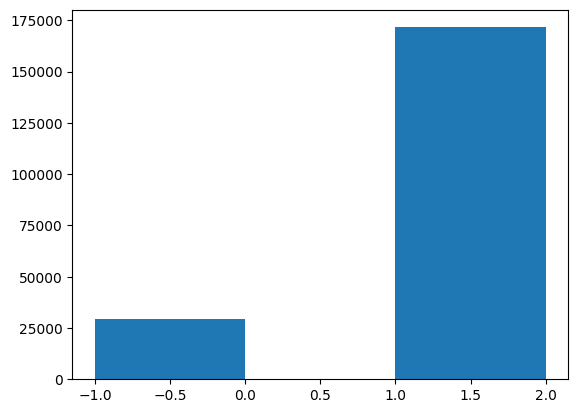

In [16]:
classes = [1 if note>5 else -1 for note in notes]
plt.hist(classes, bins=range(min(classes), max(classes) + 2, 1))
plt.show()

In [ ]:
corpus_positif = ' '.join(comments)
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
sorted_words[:10]

### Réequilibrage des clasees

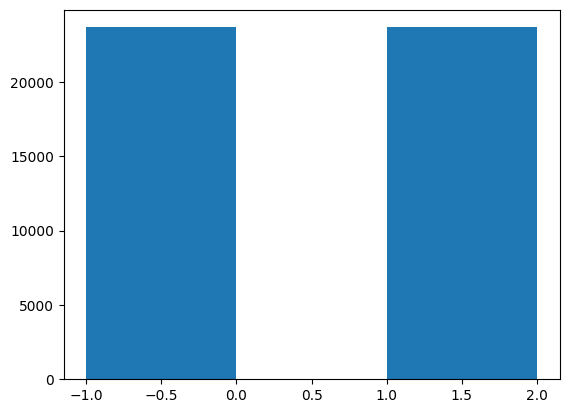

In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(comments)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, classes, test_size=0.2, random_state=0)

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
plt.hist(y_resampled, bins=range(min(y_resampled), max(y_resampled) + 2, 1))
plt.show()

In [18]:
def classifieur(vectorizer):
    X = vectorizer.fit_transform(comments)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, classes, test_size=0.2, random_state=0)
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


    # Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X_resampled, y_resampled)

    # Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, n_jobs=-1)
    lr_clf.fit(X_resampled, y_resampled)

    # Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X_resampled, y_resampled)

    pred_nb = nb_clf.predict(X_test)
    pred_lr = lr_clf.predict(X_test)
    pred_svm = svm_clf.predict(X_test)

    nb_f1 = metrics.f1_score(y_test, pred_nb, average='weighted')
    lr_f1 = metrics.f1_score(y_test, pred_lr, average='weighted')
    svm_f1 = metrics.f1_score(y_test, pred_svm, average='weighted')
    
    

    # Trouver le meilleur modèle en fonction du f1-score
    best_model = ''
    if nb_f1 > lr_f1 and nb_f1 > svm_f1:
        best_model = 'Naïve Bayes'
        model = nb_clf
    elif lr_f1 > nb_f1 and lr_f1 > svm_f1:
        best_model = 'Logistic Regression'
        model = lr_clf
    else:
        best_model = 'SVM'
        model = svm_clf
    
    print(f"Best model: {best_model}")
    print(f"{best_model.capitalize()} accuracy: {metrics.accuracy_score(y_test, model.predict(X_test))}     f1-score: {metrics.f1_score(y_test, model.predict(X_test), average='weighted')}")

    # Obtenir les caractéristiques les plus importantes pour le meilleur modèle
    n = 10
    feature_weights = model.coef_[0]
    top_features = {
        'positive': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[-n:][::-1]],
        'negative': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[:n]]
    }

    
    print("Top 10 mots positifs: ", top_features['positive'])
    print("Top 10 mots négatifs: ", top_features['negative'])

### CountVectorizer

In [19]:
def count_vectorizer(**count_vectorizer_args):
    vectorizer = CountVectorizer(**count_vectorizer_args)
    return classifieur(vectorizer)

### TdfidfVectorizer

In [20]:
def tfidf_vectorizer(**tfidf_vectorizer_args):
    vectorizer = TfidfVectorizer(**tfidf_vectorizer_args)
    return classifieur(vectorizer)

## Variantes et évaluations

In [21]:
count_vectorizer()

Best model: Logistic Regression
Logistic regression accuracy: 0.8276890944353275     f1-score: 0.8455592223609294
Top 10 mots positifs:  ['bémol', 'maximale', 'bravo', 'foncez', 'excellent', 'hésitez', 'jouissif', 'avaler', 'cultes', 'rareté']
Top 10 mots négatifs:  ['déception', 'décevant', 'interêt', 'incompréhensibles', 'ennuyé', 'ennui', 'servira', 'chiant', 'ennuyeux', 'ennuyeuse']


In [22]:
tfidf_vectorizer()

Best model: SVM
Svm accuracy: 0.830672833059824     f1-score: 0.8479276692556876
Top 10 mots positifs:  ['bémol', 'excellent', 'bravo', 'foncez', 'maximale', 'hésitez', 'vivement', 'must', 'merveille', 'adore']
Top 10 mots négatifs:  ['déception', 'décevant', 'intérêt', 'ennuyé', 'ennuyeux', 'ennui', 'ennuie', 'chiant', 'servir', 'raté']


### Stopswords

In [23]:
count_vectorizer(stop_words=stopwords.words('french'))

Best model: Logistic Regression
Logistic regression accuracy: 0.8239096921776319     f1-score: 0.8423854144650136
Top 10 mots positifs:  ['bémol', 'maximale', 'bravo', 'foncez', 'cultes', 'excellent', 'jouissif', 'fij', 'avaler', 'défaire']
Top 10 mots négatifs:  ['décevant', 'déception', 'interêt', 'incompréhensibles', 'ennuyé', 'ennui', 'chiant', 'bancal', 'revendu', 'ennuyeux']


In [24]:
tfidf_vectorizer(stop_words=stopwords.words('french'))

Best model: Logistic Regression
Logistic regression accuracy: 0.8276393654582526     f1-score: 0.84485796022823
Top 10 mots positifs:  ['excellent', 'bémol', 'bon', 'adore', 'efficace', 'bravo', 'parfait', 'excellente', 'must', 'agréable']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuie', 'aucune', 'ennuyeux', 'décevant', 'ennui', 'malheureusement', 'aucun', 'accroché']


### Stopswords et tous les mots qui apparaissent dans plus de 75% des documents sont ignorés

In [25]:
count_vectorizer(stop_words=stopwords.words('french'), max_df=.75)

Best model: Logistic Regression
Logistic regression accuracy: 0.8239842856432443     f1-score: 0.8424449681489813
Top 10 mots positifs:  ['bémol', 'maximale', 'bravo', 'cultes', 'foncez', 'excellent', 'jouissif', 'fij', 'avaler', 'défaire']
Top 10 mots négatifs:  ['décevant', 'déception', 'interêt', 'incompréhensibles', 'ennuyé', 'ennui', 'chiant', 'bancal', 'revendu', 'ennuyeux']


In [26]:
tfidf_vectorizer(stop_words=stopwords.words('french'), max_df=.75)

Best model: Logistic Regression
Logistic regression accuracy: 0.8277636879009399     f1-score: 0.844977473983963
Top 10 mots positifs:  ['excellent', 'bémol', 'bon', 'adore', 'efficace', 'bravo', 'parfait', 'excellente', 'must', 'agréable']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuie', 'aucune', 'ennuyeux', 'décevant', 'ennui', 'malheureusement', 'aucun', 'accroché']


### Stopswords et tous les mots qui apparaissent dans plus de 20% des documents sont ignorés

In [27]:
count_vectorizer(stop_words=stopwords.words('french'), max_df=.2)

Best model: Logistic Regression
Logistic regression accuracy: 0.8206524441792232     f1-score: 0.839781479500523
Top 10 mots positifs:  ['bémol', 'maximale', 'bravo', 'foncez', 'excellent', 'cultes', 'jouissif', 'tendues', 'fij', 'avaler']
Top 10 mots négatifs:  ['déception', 'décevant', 'interêt', 'ennui', 'incompréhensibles', 'ennuyé', 'bancal', 'atteint', 'indigeste', 'revendu']


In [28]:
tfidf_vectorizer(stop_words=stopwords.words('french'), max_df=.2)

Best model: Logistic Regression
Logistic regression accuracy: 0.824282659505694     f1-score: 0.8420952863252054
Top 10 mots positifs:  ['excellent', 'bémol', 'adore', 'efficace', 'bravo', 'agréable', 'parfait', 'excellente', 'must', 'attention']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuie', 'aucune', 'ennui', 'décevant', 'ennuyeux', 'aucun', 'accroché', 'malheureusement']


### Stopswords et les 100 termes les plus fréquents

In [29]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100])

Best model: Logistic Regression
Logistic regression accuracy: 0.8181162663484012     f1-score: 0.8376883343620185
Top 10 mots positifs:  ['bémol', 'maximale', 'foncez', 'excellent', 'cultes', 'bravo', 'jouissif', 'tendues', 'fij', 'avaler']
Top 10 mots négatifs:  ['déception', 'décevant', 'ennuyé', 'incompréhensibles', 'ennui', 'interêt', 'indigeste', 'revendu', 'bancal', 'error']


In [30]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100])

Best model: Logistic Regression
Logistic regression accuracy: 0.8249042717191307     f1-score: 0.8425346162158632
Top 10 mots positifs:  ['excellent', 'bémol', 'efficace', 'adore', 'agréable', 'bravo', 'parfait', 'excellente', 'must', 'attention']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuie', 'aucune', 'ennui', 'décevant', 'accroché', 'ennuyeux', 'aucun', 'malheureusement']


### Stopswords et les 1 000 termes les plus fréquents

In [31]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:1000])

Best model: Logistic Regression
Logistic regression accuracy: 0.7739072057287781     f1-score: 0.8010432336567275
Top 10 mots positifs:  ['maximale', 'jouissif', 'régal', 'tendues', 'rythmées', 'have', 'foncez', 'animées', 'perfection', 'festivals']
Top 10 mots négatifs:  ['décevant', 'ennuyé', 'revendu', 'ennui', 'ennuyeux', 'désolé', 'raté', 'bancal', 'supplice', 'chiant']


In [32]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:1000])

Best model: Logistic Regression
Logistic regression accuracy: 0.7860659406236014     f1-score: 0.8098907713885535
Top 10 mots positifs:  ['vivement', 'tendues', 'jouissif', 'régal', 'foncez', 'addictif', 'have', 'incontournable', 'subtil', 'vin']
Top 10 mots négatifs:  ['ennui', 'décevant', 'ennuyeux', 'ennuyé', 'accroché', 'plat', 'raté', 'bof', 'désolé', 'convaincu']


### Stopswords et les 10 000 termes les plus fréquents

In [33]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:10000])

Best model: Logistic Regression
Logistic regression accuracy: 0.7081903625242428     f1-score: 0.7437839060640513
Top 10 mots positifs:  ['malice', 'alterne', 'préparez', 'décuplé', 'garantissent', 'haletant', 'garanties', 'distille', 'grincheux', 'pilier']
Top 10 mots négatifs:  ['déchanté', 'annonçait', 'maboul', 'meyklar', 'résumant', 'ratage', 'ennuyés', 'platitude', 'insisté', 'emmerde']


In [34]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:10000])

Best model: Logistic Regression
Logistic regression accuracy: 0.7184593962902183     f1-score: 0.7509699343125421
Top 10 mots positifs:  ['malice', 'alterne', 'haletant', 'clochemerle', 'foireuses', 'legrenierludique', 'renouvèlement', 'décuplé', 'grincheux', 'excellemment']
Top 10 mots négatifs:  ['ennuyés', 'déchanté', 'daube', 'ratage', 'annonçait', 'nullité', 'supplice', 'maboul', 'promettait', 'péniblement']


### Stopswords et les 40 000 termes les plus fréquents

In [35]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:40000])

Best model: SVM
Svm accuracy: 0.8215972947436472     f1-score: 0.8028999519581861
Top 10 mots positifs:  ['secouent', 'patrouillant', 'chevreuil', 'bizzbon', 'vénèrent', 'fluyide', 'acre', 'multicritères', 'philippine', 'spooks']
Top 10 mots négatifs:  ['adelle', 'déshydratation', 'révéla', 'paramêtres', 'gonflées', 'afflux', 'altruistes', 'chantre', 'dégoutté', 'plafonné']


### Stopswords et les 100 000 termes les plus fréquents

In [36]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000])

Best model: Logistic Regression
Logistic regression accuracy: 0.8534487045601472     f1-score: 0.7870095429930435
Top 10 mots positifs:  ['agrã', 'organigramme', 'expliquéess', 'icite', 'enquiquinent', 'overboard', 'anmoins', 'systã', 'sã', 'agre']
Top 10 mots négatifs:  ['internationalisation', 'otarie', 'fã', 'ensembleil', 'innovantrater', 'intimation', 'intant', 'ambiancejouables', 'aéatoire', 'pfeee']


In [37]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000])

Best model: Logistic Regression
Logistic regression accuracy: 0.8536724849569844     f1-score: 0.7870738548404093
Top 10 mots positifs:  ['enquiquinent', 'expliquéess', 'icite', 'organigramme', 'rã', 'overboard', 'gatifs', 'anmoins', 'agrã', 'ries']
Top 10 mots négatifs:  ['otarie', 'internationalisation', 'étonnait', 'évertuais', 'intant', 'ensembleil', 'universl', 'achimie', 'achetermoche', 'intimation']


### Bigrammes

In [40]:
count_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 2))

Best model: Logistic Regression
Logistic regression accuracy: 0.853175195186235     f1-score: 0.8668570455519624
Top 10 mots positifs:  ['excellent', 'bémol', 'bravo', 'must', 'bon petit', 'adore', 'très bon', 'merveille', 'excellente', 'jouissif']
Top 10 mots négatifs:  ['déception', 'décevant', 'ennuyeux', 'ennui', 'ennuie', 'accroché', 'ennuyé', 'bof', 'convaincu', 'chiant']


In [41]:
tfidf_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 2))

Best model: SVM
Svm accuracy: 0.8638669252573474     f1-score: 0.8754473765443802
Top 10 mots positifs:  ['excellent', 'bon jeu', 'bémol', 'très bon', 'adore', 'bon petit', 'bravo', 'parfait', 'must', 'efficace']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuie', 'ennui', 'malheureusement', 'ennuyeux', 'décevant', 'aucune', 'trop', 'accroché']


In [42]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000], ngram_range=(1, 2))

Best model: SVM
Svm accuracy: 0.8534238400716098     f1-score: 0.7869496877775172
Top 10 mots positifs:  ['expliquéess', 'organigramme', 'icite', 'enquiquinent', 'overboard', 'anmoins', 'familialvariante', 'fandart', 'dirtvous', 'énormerailroad']
Top 10 mots négatifs:  ['otarie', 'internationalisation', 'alep', 'étonnait', 'achetermoche', 'aéatoire', 'intimation', 'intant', 'évertuais', 'étymologie']


In [43]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000], ngram_range=(1, 2))

Best model: SVM
Svm accuracy: 0.8535730270028346     f1-score: 0.7870241917929631
Top 10 mots positifs:  ['expliquéess', 'icite', 'organigramme', 'enquiquinent', 'overboard', 'anmoins', 'trã dã', 'rã', 'ries', 'concluerais']
Top 10 mots négatifs:  ['premiã trã', 'otarie', 'internationalisation', 'évertuais', 'engleterre', 'pfeee', 'encan', 'achimie', 'innovantrépétitif', 'innovantrater']


In [44]:
count_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 2), max_df=0.5)

Best model: Logistic Regression
Logistic regression accuracy: 0.8530260082550102     f1-score: 0.8667075087623951
Top 10 mots positifs:  ['excellent', 'bémol', 'bravo', 'must', 'bon petit', 'adore', 'très bon', 'merveille', 'excellente', 'jouissif']
Top 10 mots négatifs:  ['déception', 'décevant', 'ennuyeux', 'ennui', 'ennuie', 'accroché', 'ennuyé', 'bof', 'convaincu', 'intérêt']


In [45]:
tfidf_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 2), max_df=0.5)

Best model: SVM
Svm accuracy: 0.8641901636083346     f1-score: 0.8757067224923097
Top 10 mots positifs:  ['excellent', 'bon jeu', 'bémol', 'très bon', 'adore', 'bon petit', 'bravo', 'parfait', 'must', 'efficace']
Top 10 mots négatifs:  ['déception', 'intérêt', 'ennuie', 'ennui', 'malheureusement', 'ennuyeux', 'décevant', 'aucune', 'trop', 'accroché']


### Trigrammes

In [46]:
count_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 3))

Best model: Logistic Regression
Logistic regression accuracy: 0.8544184196131086     f1-score: 0.8678376886595948
Top 10 mots positifs:  ['excellent', 'bémol', 'adore', 'bravo', 'must', 'très sympa', 'bonheur', 'parfait', 'excellente', 'merveille']
Top 10 mots négatifs:  ['déception', 'ennuyeux', 'décevant', 'ennuie', 'ennui', 'bof', 'accroché', 'intérêt', 'ennuyé', 'convaincu']


In [47]:
tfidf_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 3))

Best model: SVM
Svm accuracy: 0.8650604207071461     f1-score: 0.8762221900996516
Top 10 mots positifs:  ['excellent', 'bon jeu', 'bémol', 'adore', 'très bon', 'agréable', 'rapide', 'parfait', 'aussi', 'efficace']
Top 10 mots négatifs:  ['intérêt', 'déception', 'ennuie', 'trop', 'rien', 'malheureusement', 'aucune', 'ennui', 'ennuyeux', 'déçu']


In [48]:
count_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000], ngram_range=(1, 3))

Best model: SVM
Svm accuracy: 0.8533492466059973     f1-score: 0.7869124315185829
Top 10 mots positifs:  ['expliquéess', 'organigramme', 'icite', 'enquiquinent', 'overboard', 'anmoins', 'caernafon', 'glanables', 'vuelta', 'kasl']
Top 10 mots négatifs:  ['otarie', 'internationalisation', 'intant', 'ensembleil', 'achimie', 'ambiancejouables', 'encan', 'alep', 'innovantrater', 'achetermoche']


In [49]:
tfidf_vectorizer(stop_words=stopwords.words('french')+sorted_words[:100000], ngram_range=(1, 3))

Best model: Logistic Regression
Logistic regression accuracy: 0.8535481625142971     f1-score: 0.7870117752441702
Top 10 mots positifs:  ['enquiquinent', 'expliquéess', 'icite', 'organigramme', 'overboard', 'rã', 'anmoins', 'ries', 'gatifs', 'awayfar']
Top 10 mots négatifs:  ['otarie', 'internationalisation', 'intant', 'étincelantes', 'intimation', 'innovantrater', 'universl', 'innovantrépétitif', 'ensembleil', 'étymologie']


In [50]:
count_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 3), max_df=0.5)

Best model: Logistic Regression
Logistic regression accuracy: 0.8552140832463077     f1-score: 0.8685220431511718
Top 10 mots positifs:  ['excellent', 'bémol', 'adore', 'bravo', 'must', 'très sympa', 'bonheur', 'excellente', 'merveille', 'parfait']
Top 10 mots négatifs:  ['déception', 'ennuyeux', 'décevant', 'ennui', 'ennuie', 'accroché', 'bof', 'intérêt', 'ennuyé', 'convaincu']


In [51]:
tfidf_vectorizer(stop_words=stopwords.words('french'), ngram_range=(1, 3), max_df=0.5)

Best model: SVM
Svm accuracy: 0.8649858272415336     f1-score: 0.8761364373566314
Top 10 mots positifs:  ['excellent', 'bon jeu', 'bémol', 'adore', 'très bon', 'agréable', 'rapide', 'parfait', 'aussi', 'efficace']
Top 10 mots négatifs:  ['intérêt', 'déception', 'ennuie', 'trop', 'rien', 'malheureusement', 'aucune', 'ennui', 'ennuyeux', 'déçu']


### Stemming

In [52]:
# fonction de preprocessing : stemming 
f = lambda doc: stem(doc) 

In [53]:
count_vectorizer(preprocessor=f)

Best model: Logistic Regression
Logistic regression accuracy: 0.8195832711721119     f1-score: 0.8386792351942114
Top 10 mots positifs:  ['hériti', 'bémol', 'déchaîn', 'fonc', 'filt', 'raret', 'visibil', 'consensuel', 'néglig', 'défair']
Top 10 mots négatifs:  ['décept', 'atz', 'interêt', 'décev', 'scandal', 'sens', 'lourdeur', 'vertical', 'sournoiser', 'peopl']


In [54]:
tfidf_vectorizer(preprocessor=f)

Best model: Logistic Regression
Logistic regression accuracy: 0.8244567109254562     f1-score: 0.842309772327326
Top 10 mots positifs:  ['excellent', 'bémol', 'bon', 'ador', 'bravo', 'parf', 'agréabl', 'parfait', 'must', 'hésit']
Top 10 mots négatifs:  ['décept', 'ennui', 'intérêt', 'aucun', 'pas', 'décev', 'répétit', 'rien', 'idé', 'malheur']


### Autres modeles

#### XGBoost

In [55]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
classes = le.fit_transform(classes)


cv = CountVectorizer(stop_words=stopwords.words('french'))

X = cv.fit_transform(comments)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, classes, test_size=0.2, random_state=0)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

report = metrics.classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.339053,0.802149,0.476639,5863.0000
1,0.955972,0.733139,0.829857,34355.0000
accuracy,0.743200,0.743200,0.743200,0.7432
macro avg,0.647512,0.767644,0.653248,40218.0000
weighted avg,0.866037,0.743200,0.778365,40218.0000


#### Neural network

In [56]:
cv = CountVectorizer(stop_words=stopwords.words('french'))

X = cv.fit_transform(comments)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, classes, test_size=0.2, random_state=0)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

model = neural_network.MLPClassifier()
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

report = metrics.classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.399298,0.794986,0.531592,5863.000000
1,0.957891,0.795896,0.869412,34355.000000
accuracy,0.795763,0.795763,0.795763,0.795763
macro avg,0.678594,0.795441,0.700502,40218.000000
weighted avg,0.876459,0.795763,0.820164,40218.000000
